In [12]:
import sys
import os
import glob
from collections import Counter
import rstoolbox
import pandas as pd
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import re
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from rstoolbox.io import write_fasta

In [2]:
rstoolbox.utils.format_Ipython()

In [11]:
#specify input files for each selection conditions (input) and define how to compute the enrichment (enrich)
input_ = {'5C4': {'10nMFab':'5C4_Fab_10nM.fastq', '1uM':'5C4_IgG_1uM.fastq',}, 'D25': {'100pM':'D25_Fab_100pM.fastq', '10nM':'D25_Fab_10nM.fastq'}}
enrich_ = {'5C4': ['10nMFab', '1uM'], 'D25': ['100pM', '10nM']}

In [7]:
# defining analysis functions
def read_fastq(filename):
    """
    Reads a FASTQ file and stores the ID together with the sequence.
    :param filename: FASTQ filename.
    :return: Array of tuples containing ID and sequence information.
    """
    # Empty array to store tuples of ID & sequence information
    fastq = []

    # Create a file handle for parsing
    with open(filename, 'rU') as fastq_file:
        # Parse the ID, sequence, and quality information of each entry
        for title, seq, qual in FastqGeneralIterator(fastq_file):
            fastq.append((seq.rstrip('>')))  # get rid of trailing '>' characters
    return fastq
def translate_all(seqlist, matches):
    for i, seq in enumerate(seqlist):
        seqlist[i] = translate_3frames(seq, matches)
    return seqlist

def adapt_length(seqlist):
    for i, seq in enumerate(seqlist):
        m = re.search('AS(.*)GS', seq)
        if m:
            seqlist[i] = m.group(1)
    return seqlist

def translate_3frames(sequence, matches):
    protein_frame = []
    
    for i in range(0, 3):
        protein_frame.append(translate_dna_sequence(sequence[i:]))
        
    match_max = len(matches)
    match_count = [0,] * len(protein_frame)
    for i, p in enumerate(protein_frame):
        for m in matches:
            if re.search(m, p):
                match_count[i] += 1
    try:
        i = match_count.index(match_max)
        return protein_frame[i]
    except ValueError:
        return ""

def translate_dna_sequence(sequence):
    codontable = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
    'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W',}
    protein=""
    last_codon_start=len(sequence)-2
    for start in range(0,last_codon_start,3):
        codon=sequence[start:start+3]
        aa=codontable.get(codon, 'X')
        protein = protein + aa
    return protein
def read_count_fastq(jobid, filename, matches):
    data = read_fastq(filename)
    data = translate_all(data, matches)
    data = adapt_length(data)
    counts = Counter(data)
    df = pd.DataFrame.from_dict(counts, orient='index')
    df = df.sort_values(0, ascending=False)
    df.reset_index(level=0, inplace=True)

    return df.rename(columns={'index': 'seq', 0:jobid})

def func2(jobid, inputb, matches):
    data = []
    for cond in inputb:
        data.append(read_count_fastq(jobid + '_' + cond, inputb[cond], matches))
    df = reduce(lambda left, right: pd.merge(left, right, on='seq', how='outer'), data).fillna(0)
    return df
    
def func1(input_, matches):
    data = []
    for binder in input_:
        data.append(func2(binder, input_[binder], matches))
    df = reduce(lambda left, right: pd.merge(left, right, on='seq', how='outer'), data).fillna(0)
    df['len'] = df.apply(lambda row: len(row['seq']), axis=1)
    #df['enrichment'] = df.apply(enrichment_to_cond)
    df['enrichment_5C4'] = df['5C4_10nMFab']/df['5C4_1uM']
    df['enrichment_D25'] = df['D25_100pM']/df['D25_10nM']
    df.replace({'inf': '-1'}, regex=True, inplace=True)
    return df
g=func1(input_, ['KNY', 'KE'])
total_row = g.head()

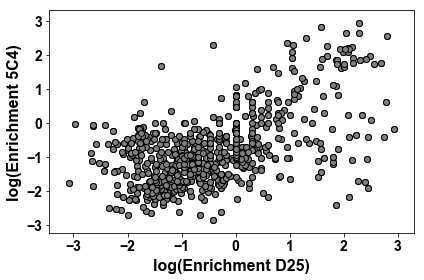

In [10]:
#plot enrichment 
x=np.log10(df_clean58['enrichment_D25'],dtype='float64')
y=np.log10(df_clean58['enrichment_5C4'],dtype='float64')
plt.scatter(x, y, c='grey', edgecolors='black')
plt.ylabel('log(Enrichment 5C4)',fontname="Arial", weight="bold", fontsize="16")
plt.xlabel('log(Enrichment D25)',fontname="Arial",weight="bold",fontsize="16"'\n')
plt.xticks(fontsize=14, fontname="Arial", weight="bold")
plt.yticks(fontsize=14, fontname="Arial", weight="bold")
plt.tight_layout()
plt.show()
#plt.savefig('enrichment_DNS0.pdf')

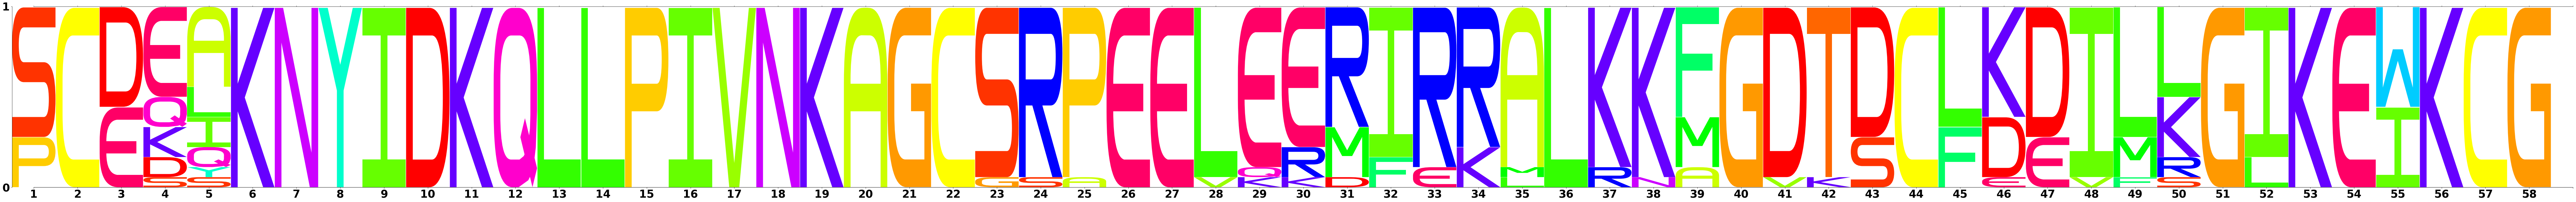

In [16]:
# create sequence logo of sequences that are only enriched for D25 but not for 5C4
D25_only=df_clean.filter(['seq','5C4_10nMFab','5C4_1uM','D25_100pM','D25_10nM','enrichment_5C4','enrichment_D25','len'], axis=1)
designfD25 = D25_only.loc[(D25_only["enrichment_D25"] > 40) & (D25_only["enrichment_5C4"] <1)].sort_values('enrichment_D25',ascending=False)
designfD25 = rstoolbox.components.DesignFrame(designfD25.rename(columns={'seq': 'sequence_A'}))
designfD25 = designfD25.reset_index().rename(columns={'index':'description'})
designfD25 = designfD25[designfD25['len'] == 58]
designfD25.add_reference_sequence('A', "SCEEAKNYIDKQLLPIVNKAGCGSAEEVQKDIEKALRNAGVKDCLEDILRGIKEIKCG")
designfD25 = designfD25.identify_mutants('A')
fig, axes = rstoolbox.plot.logo_plot(designfD25, "A", refseq=False)
plt.tight_layout()
plt.show()
#plt.savefig('logo.svg')
